Analyze the progression of the frontier points algorithm with temperature change


In [1]:
pwd

'/Users/ralfbanisch/Documents/git/DFM/interactivePython'

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import os
sys.path.append('/Users/ralfbanisch/Documents/git/DFM/srcDiffmap')

import mdtraj as md

import integrator
import sampler #as sampler
import model #as model
import diffusionmap as dm
import statistics_dfm as stat

import numpy as np
from simtk import openmm, unit
from openmmtools.constants import kB

import model
#mdl=model.Model('Dimer')
mdl=model.Model('Lemon')
print (mdl.x_unit)
print('System has %d particle(s)' % mdl.system.getNumParticles())
print (mdl.testsystem.positions)
X0=mdl.testsystem.positions.value_in_unit(mdl.x_unit)
#print('Initial distance is %f' % np.linalg.norm(X0[0,:]-X0[ 1,:]))

algoVect=0

# parameters
# this is the target temperature 
T=300.0
temperature =  T * unit.kelvin#300 * unit.kelvin
kT = kB * temperature


gamma = 1.0 / unit.picosecond
dt = 2.0 * unit.femtosecond

TemperatureTAMDFactor=30.0
massScale=50.0

gammaScale=100.0
kappaScale=1000.0

print("TemperatureTAMDFactor = " + repr(TemperatureTAMDFactor))
temperatureAlpha= (T*TemperatureTAMDFactor)* unit.kelvin

print('Gamma is '+repr(gamma))
print('Temperature is '+repr(temperature))
print('Temperature TAMD '+repr(TemperatureTAMDFactor)+'xTemperature')
print('Mass alpha is '+repr(massScale)+'x Mass')



# simulation class sampler takes integrator class with chosen parameters as input
integrator=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature, temperatureAlpha=temperatureAlpha, dt=dt, massScale=massScale, gammaScale=gammaScale, kappaScale=kappaScale)
samplerAlgo=sampler.Sampler(model=mdl, integrator=integrator, algorithm=0, dataFileName='Data')

# nrSteps is number of steps for each nrRep , and iterate the algo nrIterations times - total simulation time is nrSteps x nrIterations
# nrSteps=args.nrSteps
# nrEquilSteps = 10 #10000
# nrIterations=args.niterations
# nrRep=args.nreplicas

algoNames=samplerAlgo.algorithmName

simulatedTemperature=300

print(samplerAlgo.model.testsystem.topology)

Dimer model: double-well with 2 states
State1: r=Quantity(value=1.55, unit=angstrom)
State2: r=Quantity(value=2.55, unit=angstrom)
Lemon model: lemon-lice potential with 7 states and 1 reaction coordinate
angstrom
System has 2 particle(s)
[[ 1.   0.1  0.1]
 [ 1.   0.1  0.1]] A
TemperatureTAMDFactor = 30.0
Gamma is Quantity(value=1.0, unit=/picosecond)
Temperature is Quantity(value=300.0, unit=kelvin)
Temperature TAMD 30.0xTemperature
Mass alpha is 50.0x Mass
79.4503886762 K
<Topology; 1 chains, 1 residues, 2 atoms, 0 bonds>


In [3]:
colorList=['red', 'blue', 'black', 'green']
    
# copy values for the two states from above
min1=1.55*model.unit.angstroms
min2=2.55*model.unit.angstroms


In [4]:
#'/Users/zofia/github/DFM/Data/Std/Traj/*.h5'


#---------------- load trajectories: for example from simulation at higher temperature
import glob



def loadData(fileName):
    numpy_vars = []
    #for np_name in glob.glob('/Users/zofia/github/DFM/Data/Std/Traj/T'+repr(simulatedTemperature)+ '/*.h5'):
    for np_name in glob.glob(fileName+'*.h5'):
        numpy_vars.append(md.load(np_name))

    traj = numpy_vars
    print(len(traj))



    Xmdtraj=list()
    for i in range(len(traj)):
        #print(traj[i][0].xyz)
        #Xmdtraj.append(md.Trajectory(traj[i].xyz, samplerAlgo.model.testsystem.topology))#mdl.testsystem.topology) )
        Xmdtraj.append(md.Trajectory(traj[i].xyz, mdl.testsystem.topology))

    print(Xmdtraj[0].xyz.shape[2])
    L=int(Xmdtraj[0].xyz.shape[0]*len(traj))
    nrP=int(Xmdtraj[0].xyz.shape[1])
    print(nrP)
    D=int(Xmdtraj[0].xyz.shape[2])
    X=np.zeros((L, nrP, D))
    for i in range(0,len(Xmdtraj)):
            X[i*len(Xmdtraj[i].xyz):(i+1)*len(Xmdtraj[i].xyz),:,:]=Xmdtraj[i].xyz

    return X, traj


In [40]:
mdl.testsystem.topology

<Topology; 1 chains, 1 residues, 2 atoms, 0 bonds>

In [59]:
nameData = '/Users/ralfbanisch/Documents/git/DFM/Data/frontier_points_change_temperature/Traj/'
#nameData = '/Users/ralfbanisch/Documents/git/DFM/Data/frontier_points/Traj/'
#nameData = '/Users/ralfbanisch/Documents/git/DFM/Data/Std/Traj/'

X_FT, traj_FT = loadData(nameData)


10
3
2


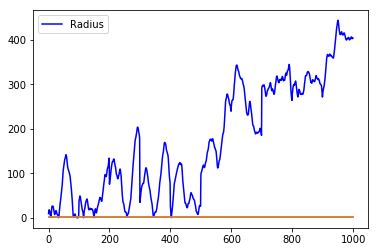

In [60]:

# import mdtraj as md
# Xmdtraj=list()
# for i in range(len(traj)):
#     Xmdtraj.append(md.Trajectory(traj[i].xyz, mdl.testsystem.topology) )

# print(Xmdtraj[0].xyz.shape[2])
# L=int(Xmdtraj[0].xyz.shape[0]*len(traj))
# nrP=int(Xmdtraj[0].xyz.shape[1])
# D=int(Xmdtraj[0].xyz.shape[2])
# X=np.zeros((L, nrP, D))
# for i in range(0,len(Xmdtraj)):
#         X[i*len(Xmdtraj[i].xyz):(i+1)*len(Xmdtraj[i].xyz),:,:]=Xmdtraj[i].xyz

# print(X.shape)

#---------------- radius 

def radius(X):

    return np.linalg.norm(X[:,0,:]-X[:,1,:], 2, axis=1)

def radius1point(X):
    
    return np.linalg.norm(X[0,:]-X[1,:], 2)
    

r=radius(X_FT)


# plt.plot(range(len(radius(X_STD))), radius(X_STD),'r')

# plt.plot(range(len(r)), np.ones(len(r))*min1)
# plt.plot(range(len(r)), np.ones(len(r))*min2)
# plt.legend(['STD'])


# plt.show()

# plt.plot(range(len(radius(X_F))), radius(X_F), 'g')
# plt.plot(range(len(r)), np.ones(len(r))*min1)
# plt.plot(range(len(r)), np.ones(len(r))*min2)
# plt.legend(['F'])
# plt.show()
plt.plot(range(len(radius(X_FT))), radius(X_FT), 'b')

plt.plot(range(len(r)), np.ones(len(r))*min1)
plt.plot(range(len(r)), np.ones(len(r))*min2)
plt.legend(['Radius'])


plt.show()





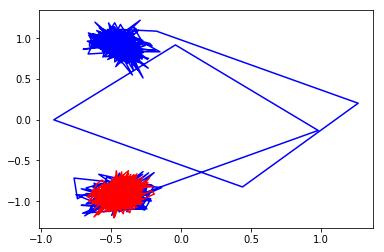

In [61]:
np.shape(X_FT)
#traj_FT[0]
plt.plot(X_FT[:,0,0],X_FT[:,0,1], 'b')
plt.plot(X_FT[:,1,0],X_FT[:,1,1], 'r')
plt.show()

In [29]:
#---------- VISUALISATION OF THE MOLECULE
#align according to first frame

traj=traj_FT
traj[0]=traj[0].superpose(traj[0][0])
tpl=traj[0].topology
print(tpl)
import nglview as nv
view = nv.show_mdtraj(traj[0])

view.add_representation('spacefill', selection='all' )
view.frame = 10
view

#--- saving as gif: does not work :(
# from nglview.contrib.movie import MovieMaker
# movie = MovieMaker(view, output='my.gif')
# movie.make()


<mdtraj.Topology with 1 chains, 1 residues, 2 atoms, 0 bonds>


In [30]:
def plotResults(freeEnergyUnWeighted, freeEnergyWeighted, V1, lm, Epot, r):
    print(freeEnergyUnWeighted)
    freeEnergy=freeEnergyUnWeighted
    #plt.scatter(v1TMDiffmap, Epot)
    plt.plot(V1[lm], freeEnergy, '*-b')
    plt.xlabel('V1')
    plt.ylabel('Free energy ln(pi(V1(x)))')
    plt.show()

    plt.plot(r[lm], freeEnergyWeighted, '*-b')
    plt.plot(r[lm], freeEnergyUnWeighted, '*-r')
    plt.xlabel('r')
    plt.ylabel('Free energy ln(pi(V1(x)))')
    plt.show()


    plt.scatter(  V1, Epot)
    plt.plot( V1[lm],Epot[lm], '*-r')
    plt.xlabel('V1')
    plt.ylabel('potential energy')
    plt.show()

    plt.scatter(  r, Epot, c=V1)
    plt.plot(  r[lm], Epot[lm], '-*r')
    plt.xlabel('r')
    plt.ylabel('potential energy')
    plt.show()

    plt.scatter(  r, V1)
    plt.plot(  r[lm], V1[lm], '*-r')
    plt.xlabel('r')
    plt.ylabel('V1')
    plt.show()
    
def plotAndSaveResults(freeEnergyUnWeighted, freeEnergyWeighted, V1, lm, Epot, r):
    #print(freeEnergyUnWeighted)
    #freeEnergy=freeEnergyUnWeighted
    #plt.scatter(v1TMDiffmap, Epot)
    plt.plot(V1[lm], freeEnergyUnWeighted, '*-b')
    plt.xlabel('V1')
    plt.ylabel('Free energy ln(pi(V1(x)))')
    plt.show()#('V1_freeEn.png')

    plt.plot(r[lm], freeEnergyWeighted, '*-b')
    plt.plot(r[lm], freeEnergyUnWeighted, '*-r')
    plt.xlabel('r')
    plt.ylabel('Free energy ln(pi(V1(x)))')
    plt.show()
    #plt.save('r_freeEn.png')

    plt.scatter(  V1, Epot)
    plt.plot( V1[lm],Epot[lm], '*-r')
    plt.xlabel('V1')
    plt.ylabel('potential energy')
    plt.show()
    
    
    #plt.save('V1_ePot.png')

    plt.scatter(  r, Epot, c=V1)
    plt.plot(  r[lm], Epot[lm], '-*r')
    plt.xlabel('r')
    plt.ylabel('potential energy')
    plt.show()
   
    plt.scatter(  r, Epot, c=V1)
    #plt.plot(  r[lm], Epot[lm], '-*r')
    plt.colorbar()
    plt.xlabel('radius')
    plt.ylabel('potential energy')
    plt.show()
   
    #plt.save('r_ePot.png')

    plt.scatter(  r, V1)
    plt.plot(  r[lm], V1[lm], '*-r')
    plt.xlabel('r')
    plt.ylabel('V1')
    plt.show()
    
    plt.scatter(  r, V1)
    #plt.plot(  r[lm], V1[lm], '*-r')
    plt.xlabel('radius')
    plt.ylabel('dominant eigenvector')
    plt.show()
    
    plt.scatter(  r,   Epot, c=V1)
    plt.plot(  r[lm], freeEnergyUnWeighted, '-*b')
    plt.xlabel('radius')
    plt.legend(['dominant eigenvector', 'free energy'])
    plt.show()
    #plt.save('r_V1.png')
    
    plt.scatter( range(len(r)), r, c=V1)

    plt.xlabel('simulation steps')
    plt.ylabel('radius')
    plt.show()
    
def plotCompareResults(fe1, fe2, v11 , v12,  lm1, lm2, r1, r2):
    #print(freeEnergyUnWeighted)
    
  
    plt.plot(r1[lm1], fe1, '*-b')
    plt.plot(r2[lm2], fe2, '*-r')
    plt.xlabel('r')
    plt.ylabel('Free energy ln(pi(V1(x)))')
    plt.show()



In [31]:
import imp
imp.reload(sampler)
imp.reload(dm)
imp.reload(stat)

def getDominantEigenvector(tr, eps, numberOfLandmarks, smpl, model, T, method): 
        
        tr_orig=tr
        
        tmp=md.Trajectory(tr, model.testsystem.topology)
        tmp = tmp.superpose(tmp[0])
        #------ reshape data ------------------------------

        tmp =  tmp.xyz.reshape((tmp.xyz.shape[0], tmp.xyz.shape[1]*tmp.xyz.shape[2]))
                
        tr=tmp
        v1, qTarget, qEmp, Epot, kernel=sampler.dominantEigenvectorDiffusionMap(tr, eps, smpl, T, method)
        
        #qTargetNormalized = qTarget/np.sum(qTarget)
        
        #get landmarks
        lm, levelsets, linspV = dm.get_landmarks(tr, numberOfLandmarks, qTarget, v1, Epot, getLevelSets=True)
        
        levelsets, levels = dm.get_levelsets(tr, numberOfLandmarks, qTarget, v1);
        
        tr =  tr.reshape((tr_orig.shape[0], tr_orig.shape[1],tr_orig.shape[2]))
        
        return tr, levelsets, v1, lm, qEmp, Epot, qTarget


def computeFreeEnergyAtLandmarkedPoint(qTarget, qEmp, levelsets, method='weighted'):
      
        if(method=='weighted'):
            weight, Ntilde = stat.compute_weight_target_distribution(qTarget, qEmp)
        
        
        K=len(levelsets)
        
        freeEnergy=np.zeros(K)
        h=np.zeros(K)

        for k in range(0,K):
            # simple histogram
            if(method == 'raw'):
                h[k] = np.sum(len(levelsets[k]))
            elif(method=='weighted'):
#              # unbiased histogram- we can use weights!!
                h[k] = np.sum(weight[levelsets[k]])
            
        for k in range(0,K):
            if(h[k] == 0):
                freeEnergy[k] = 0 # if the bin is empty set 0
            else:
                if(method == 'raw'):
                    freeEnergy[k] = -np.log(h[k]/sum(h))
                elif(method=='weighted'):
#              
                    freeEnergy[k] =  -np.log( h[k]/sum(h) / Ntilde)
                
                
        
                
        if(method=='weighted'):
            return freeEnergy, weight, Ntilde
        else:
            return freeEnergy




In [32]:
numberOfLandmarks=50
epsilon=1

# Xshort=X_FT
# print(len(Xshort))
# while(len(Xshort)>1000):
#     Xshort=Xshort[::2]
# #Xshort=X[::10]
# print("Shape of input data: "+repr((Xshort.shape)))

# # note that samplerAlgo.T gives the target temperature from the at the beginning initialized class
# print("Target temperature is "+repr(samplerAlgo.T))



# Xsp_FT,levelsets_FT, V1_FT, lm_FT, qEmp_FT, Epot_FT, qTarget_FT =FE(Xshort, epsilon, numberOfLandmarks, samplerAlgo, samplerAlgo.model, samplerAlgo.T, 'TMDiffmap')#'TMDiffmap')#'Diffmap')

# freeEnergy_FT, weight_FT, Ntilde_FT = computeFreeEnergyAtLandmarkedPoint(qTarget_FT, qEmp_FT, levelsets_FT, method='weighted')


In [33]:
numberOfLandmarks=10
method='TMDiffmap'
X=X_FT
V1iref=list()
Xiref=list()
print(len(traj))
for i in range(1, len(traj)):
    m=(int(i*len(X)/len(traj)))
    Xi = X[:m]
    print('Current length of traj is '+repr(len(Xi)))
    while(len(Xi)>100):
         Xi=Xi[::2]
    
    print('Cut to '+repr(len(Xi)))
    Xi,lvst, V1i, lmi, qEmpi, Epoti, qTargeti =getDominantEigenvector(Xi, 1, numberOfLandmarks, samplerAlgo, samplerAlgo.model, samplerAlgo.T, method)

    V1iref.append(V1i)
    Xiref.append(Xi)
    



10
Current length of traj is 100
Cut to 100
Temperature in dominantEigenvectorDiffusionMap is Quantity(value=300.0, unit=kelvin)
constructing neighbor graph
neighbor graph done
Current length of traj is 200
Cut to 100
Temperature in dominantEigenvectorDiffusionMap is Quantity(value=300.0, unit=kelvin)
constructing neighbor graph
neighbor graph done
Current length of traj is 300
Cut to 75
Temperature in dominantEigenvectorDiffusionMap is Quantity(value=300.0, unit=kelvin)
constructing neighbor graph
neighbor graph done
Current length of traj is 400
Cut to 100
Temperature in dominantEigenvectorDiffusionMap is Quantity(value=300.0, unit=kelvin)
constructing neighbor graph
neighbor graph done
Current length of traj is 500
Cut to 63
Temperature in dominantEigenvectorDiffusionMap is Quantity(value=300.0, unit=kelvin)
constructing neighbor graph
neighbor graph done
Current length of traj is 600
Cut to 75
Temperature in dominantEigenvectorDiffusionMap is Quantity(value=300.0, unit=kelvin)
cons

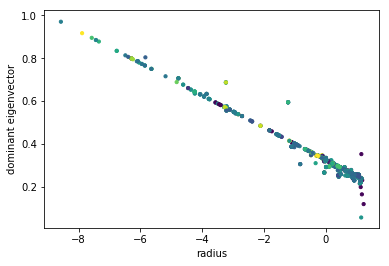

In [38]:
#plot eigenvectors with respect to every iteration
sign1=np.sign(V1iref[0][0])

for count in range(len(traj)-1):
#         sign=np.sign(V1iref[count][0])
#         #print(sign)
#         if(sign==sign1):
            
#             pass
#         else:
#             print('change sign')
#             V1iref[count]=-1*V1iref[count]
        maxV1idx = np.argmax(V1iref[count])
        plt.scatter(Xiref[count][:,0,0], Xiref[count][:,0,1], c = V1iref[count], s=10)
        #plt.scatter(radius(Xiref[count]), V1iref[count], s=10)
        #plt.scatter(radius1point(Xiref[count][maxV1idx]), V1iref[count][maxV1idx],c='r',  s=20)
        plt.xlabel('radius')
        plt.ylabel('dominant eigenvector')
plt.show()

In [34]:
np.shape(Xiref[1])

(100, 2, 3)

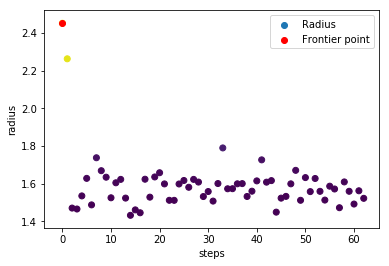

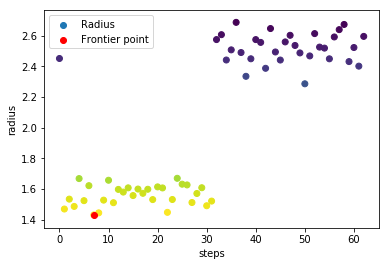

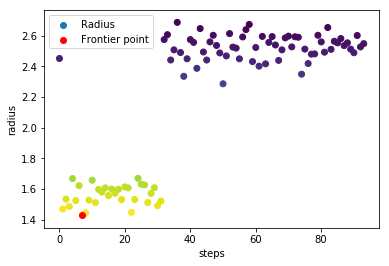

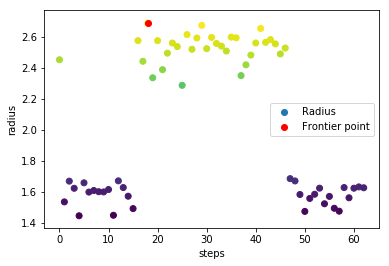

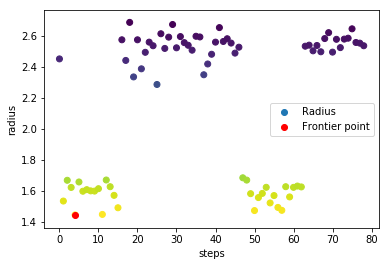

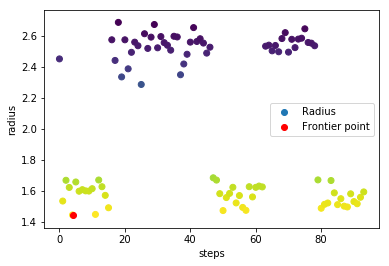

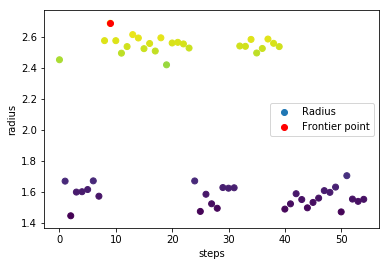

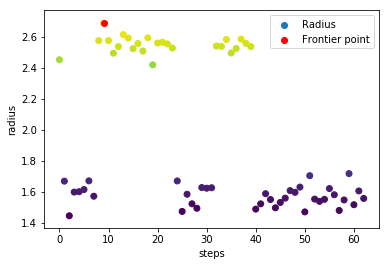

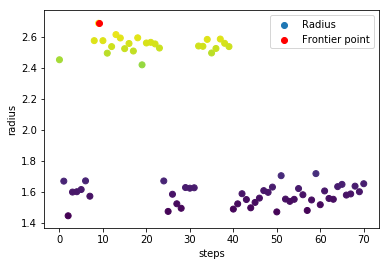

In [36]:
#plot trajectories with respect to every iteration

for count in range(len(traj)-1):
        maxV1idx = np.argmax(V1iref[count])
        
        plt.scatter(range(len(radius(Xiref[count]))), radius(Xiref[count]),c=V1iref[count])
        
        plt.scatter(maxV1idx, radius1point(Xiref[count][maxV1idx]),c='r')
        plt.legend(['Radius','Frontier point'])
        plt.ylabel('radius')
        plt.xlabel('steps')
        plt.show()